In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np

%pip install matplotlib tqdm
%matplotlib inline

import matplotlib.pyplot as plt
from tqdm import tqdm
import math

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Note: you may need to restart the kernel to use updated packages.
Using device: cuda


In [2]:
# Get setup info

print(f"PyTorch Version: {torch.__version__}")

if torch.cuda.is_available():
    print("-" * 30)
    print(f"CUDA Version: {torch.version.cuda}")

for i in range(torch.cuda.device_count()):
    # Calculate VRAM in GB
    vram_gb = torch.cuda.get_device_properties(i).total_memory / 1024**3
    
    print("-" * 30)
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    # Use the calculated variable here
    print(f"VRAM: {vram_gb:.2f} GB")

PyTorch Version: 2.8.0+cu128
------------------------------
CUDA Version: 12.8
------------------------------
GPU 0: NVIDIA GeForce RTX 5090
VRAM: 31.37 GB


In [3]:
# We offload training and encoding to the Rust implementation
# Here we only need it for loading and decoding tokens

import json

class SimpleBPE:

    def __init__(self):
        self.vocab = {}           # token_id -> token_string
        self.special_tokens = {}  # optional: useful for reference

    def decode(self, token_ids):
        """Decode token IDs back to text."""
        return ''.join(self.vocab[i] for i in token_ids)

    def load(self, path):
        """Load tokenizer from file."""
        with open(path) as f:
            data = json.load(f)
        self.vocab = {int(k): v for k, v in data['vocab'].items()}
        self.special_tokens = {k: int(v) for k, v in data.get('special_tokens', {}).items()}
        print(f"Tokenizer loaded from {path} (vocab size: {len(self.vocab)})")
        return self

In [4]:
# load tokenizer (train the tokenizer separately)

tokenizer = SimpleBPE().load('./data/tokenizer_bpe.json')

print(f'Vocabulary size: {len(tokenizer.vocab)} tokens')
print(f'Masked token id: {tokenizer.special_tokens.get("<MASK>", "Not found")}')
print(f'EOT token ids: {tokenizer.special_tokens.get("<|endoftext|>", "Not found")}')

# use tokenizer
def encode(text): return tokenizer.encode(text)
def decode(ids): return tokenizer.decode(ids)

Tokenizer loaded from ./data/tokenizer_bpe.json (vocab size: 8192)
Vocabulary size: 8192 tokens
Masked token id: 8191
EOT token ids: 242


In [5]:
# prepare dataset
import os

class MemmapDataset(Dataset):
    def __init__(self, path, block_size, samples_per_epoch=None, random_sample=True):
        """
        Args:
            path: Path to the .npy file
            block_size: Context length (e.g., 1024)
            samples_per_epoch: If set, defines a virtual epoch length (random sampling).
                             If None, one epoch = one full pass through data (sequential/shuffled).
        """
        if not os.path.exists(path):
            raise FileNotFoundError(f"Data file not found at {path}")
            
        # mmap_mode='r' is the magic key. It creates a read-only pointer
        # to the file on disk/OS cache without loading it all into Python RAM.
        self.data = np.load(path, mmap_mode='r')
        
        self.block_size = block_size
        
        # Total valid starting positions
        self.n_tokens = len(self.data)
        self.valid_starts = self.n_tokens - self.block_size

        self.random_sample = random_sample
        
        # If samples_per_epoch is not provided, we define length as total possible chunks
        # However, for continuous pre-training, fixed random sampling is often easier.
        if self.random_sample:
            self.length = samples_per_epoch if samples_per_epoch else self.valid_starts // self.block_size
        else:
            self.length = self.valid_starts // self.block_size

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # We ignore the specific 'idx' requested by the dataloader to implement
        # pure random sampling, which is robust for pre-training.
        # This ensures we don't worry about "boundaries" or shuffling overhead.
        
        if self.random_sample:
            start_idx = np.random.randint(0, self.valid_starts)
        else:
            start_idx = idx * self.block_size
            if start_idx > self.valid_starts: # Safety check
                start_idx = self.valid_starts
        
        # Slice from the memmap (OS handles caching this automatically)
        # We copy to a new array to ensure it's writable/contiguous for PyTorch
        chunk = self.data[start_idx : start_idx + self.block_size].astype(np.int64)
        
        # Convert to tensor
        x = torch.from_numpy(chunk)

        return x

In [6]:
# Hyperparameters

block_size = 1024
final_vocab_size = len(tokenizer.vocab)
batch_size = 32
target_batch_size = 256 # What we want mathematically (Effective Batch)
grad_accum_steps = target_batch_size // batch_size # 4 steps
n_embd = 768
n_head = 12
n_blocks = 12
MASK_TOKEN = tokenizer.special_tokens.get('<MASK>', 'Not found')

In [7]:
# NEW: Function to ensure workers don't duplicate random seeds
def get_worker_init_fn(seed=42):
    def worker_init_fn(worker_id):
        np.random.seed(seed + worker_id)
    return worker_init_fn

In [8]:
import os

cpu_count = os.cpu_count()
print(f"Number of logical CPUs (threads): {cpu_count}")

Number of logical CPUs (threads): 128


In [15]:
# 1. Install the downloader
!pip install gdown

# 2. Download (Replace the ID below with the ID from your link)
# Example link: drive.google.com/file/d/1A2B3C_YOUR_ID_HERE/view
file_id = '1PKbSRIQECqhHPBsb5-71Cn3vbRlQtV82'
url = f'https://drive.google.com/uc?id={file_id}'
output = './data/train_encoded.npy'

!gdown {url} -O {output}

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [gdown]
Downloading...
From (original): https://drive.google.com/uc?id=1PKbSRIQECqhHPBsb5-71Cn3vbRlQtV82
From (redirected): https://drive.google.com/uc?id=1PKbSRIQECqhHPBsb5-71Cn3vbRlQtV82&confirm=t&uuid=b3d2ce3d-b4e0-4a02-bc09-81fa922be431
To: /workspace/data/train_encoded.npy
100%|███████████████████████████████████████| 1.53G/1.53G [00:08<00:00, 177MB/s]


In [9]:
TRAIN_PATH = './data/train_encoded.npy'
VAL_PATH = './data/valid_encoded.npy'

train_dataset = MemmapDataset(TRAIN_PATH, block_size, samples_per_epoch=748000, random_sample=True) # 766M tokens / block_size
val_dataset = MemmapDataset(VAL_PATH, block_size, samples_per_epoch=7480, random_sample=False) # 7.7M tokens / block_size

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=16,
    worker_init_fn=get_worker_init_fn(),
    pin_memory=True, 
    persistent_workers=True,
    prefetch_factor=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

print(f"Dataset Tokens (Train): {len(train_dataset.data) / 1e6:.2f}M")
print(f"Dataset Tokens (Val):   {len(val_dataset.data) / 1e6:.2f}M")

batch = next(iter(train_loader))
print(f'\nBatch shape: {batch.shape}')

print(f'Sample decoded:\n')
print(tokenizer.decode(batch[0].tolist())[:500] + "...") # Print first 500 chars

Dataset Tokens (Train): 766.62M
Dataset Tokens (Val):   7.74M

Batch shape: torch.Size([32, 1024])
Sample decoded:

 huge room and discovering new things.
One day it was time to leave the castle. Lucy was sad, but she also felt very proud of her enormous adventure. When she was back home, she thanked her Mom and Dad for taking her on this special journey.
The end.
<|endoftext|>
Once upon a time, there was a happy bunny who loved to search. She searched the fields and the trees, sometimes finding nothing and sometimes finding something fun. 
One day, the happy bunny was searching in a meadow when she found a w...


In [10]:
print(f'Number of steps for each epoch: {len(train_loader)/grad_accum_steps}')

Number of steps for each epoch: 2921.875


In [11]:
# Token Masking

def mask_tokens(x_0, t, mask_token_id):

    # the random value mask to apply to input tensor conditional on the prob t tensor
    # torch.rand_like creates random values of uniform distribution in [0, 1)
    rand = torch.rand_like(x_0, dtype=torch.float) # [B, T]

    # mask where rand < t
    mask = rand < t.unsqueeze(1) # t.unsqueeze(1) shape [B, 1]

    # apply mask
    x_t = x_0.clone() # create a copy not a reference
    x_t[mask] = mask_token_id

    # x_t --> input
    # x_0 --> target

    return x_t, mask


In [12]:
## Loss function

def compute_loss(model, x_0, mask_token_id):
    B, T = x_0.shape

    t = torch.rand(B, device=x_0.device).clamp_min(1e-3)  # avoid crazy 1/t; Size([B])
    x_t, mask = mask_tokens(x_0, t, mask_token_id) # [B, T]

    logits = model(x_t, t) # [B, T, V]
    logits[:, :, mask_token_id] = -float('inf')  # Prevent predicting the mask token

    # Cross entropy loss at all tokens
    # reduction='none' means the loss stays a tensor
    # loss.shape: [B*T]
    ce_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), x_0.view(-1), reduction='none').view(B, T) # [B, T]

    # element-wise multiplication
    # mask.float() turn 'True's into 1.0 and 'False's into 0.0
    masked_loss_sum = (ce_loss * mask.float()).sum(dim=1) # [B]

    # scale masked_loss_sum with 1/t on each batch indepentently --CRITICAL
    # so that high masked and low masked rate examples contribute to loss of this batch roughly equally
    # essentially: scale loss with 1/t --> mean()
    # NOT: mean() --> scale loss
    loss = ((1.0 / t) * masked_loss_sum).mean() / T

    return loss

In [13]:
# time embedding

class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2

        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t.unsqueeze(1) * emb.unsqueeze(0) * 1000 # [B, 1] * [1, half_dim] = [B, half_dim]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1) # [B, dim]

        return emb

In [21]:
%pip install torchtune torchao

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.7/910.7 kB 24.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 60.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 9.3 MB/s  0:00:00 eta 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 58.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 83.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 60.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 54.1 MB/s  0:00:00m0:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 82.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.5/803.5 kB 30.2 MB/s  0:00:00
   ━━━━━━━━━

In [14]:
# Optimized MHA with Flash Attention
from torchtune.modules import RotaryPositionalEmbeddings

class MHA(nn.Module):
    def __init__(self, n_embd, n_head, dropout=0.1):
        super().__init__()
        assert n_embd % n_head == 0

        self.n_head = n_head
        self.n_embd = n_embd
        self.head_dim = n_embd // n_head
        self.dropout_rate = dropout

        self.c_attn = nn.Linear(n_embd, 3*n_embd)
        self.c_proj = nn.Linear(n_embd, n_embd)

        self.rope = RotaryPositionalEmbeddings(dim=n_embd // n_head)

        self.residual_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        
        # Prepare shapes for Flash Attention: [B, n_head, T, head_dim]
        q = q.view(B, T, self.n_head, self.head_dim)
        q = self.rope(q)
        q = q.transpose(1, 2) 
        
        k = k.view(B, T, self.n_head, self.head_dim)
        k = self.rope(k)
        k = k.transpose(1, 2)
        
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)

        # FLASH ATTENTION
        # Automatically selects the best kernel (FlashAttn v2, MemEfficient, etc.)
        # is_causal=False because this is a Masked/Diffusion model (bidirectional), not GPT
        out = F.scaled_dot_product_attention(
            q, k, v, 
            dropout_p=self.dropout_rate if self.training else 0.0,
            is_causal=False 
        )

        out = out.transpose(1, 2).contiguous().view(B, T, C)
        out = self.residual_dropout(self.c_proj(out))

        return out

Skipping import of cpp extensions due to incompatible torch version 2.8.0+cu128 for torchao version 0.14.1             Please see https://github.com/pytorch/ao/issues/2919 for more info


In [15]:
class SwiGLU(nn.Module):
    """
    SwiGLU activation function.

    This effectively implements:
    SwiGLU(x) = (xW + b) * SiLU(xV + c)

    Where the input is split into two parts: one for the 'value' path
    and one for the 'gate' path.
    """
    def forward(self, x):
        # Split the input tensor into two halves along the last dimension
        x, gate = x.chunk(2, dim=-1)
        # Apply SiLU (Swish) to the gate and multiply with the value
        return x * F.silu(gate)

In [16]:
# FFN

class FFN(nn.Module):
    def __init__(self, n_embd, dropout=0.1):
        super().__init__()
        self.c_fc = nn.Linear(n_embd, 8*n_embd)
        self.swiglu = SwiGLU()
        self.c_proj = nn.Linear(4*n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x) # [B, T, C]@[C, 4*C]=[B, T, 4*C]
        x = self.swiglu(x)
        x = self.c_proj(x) # [B, T, 4*C]@[4*C, C]=[B, T, C]
        x = self.dropout(x) # [B, T, C]

        return x

In [17]:
# Block

class Block(nn.Module):
    def __init__(self, n_embd, n_head, dropout=0.1, use_time=True):
        super().__init__()
        self.use_time = use_time
        self.rms_norm_1 = nn.RMSNorm(n_embd)
        self.rms_norm_2 = nn.RMSNorm(n_embd)
        self.attn = MHA(n_embd, n_head, dropout)
        self.ffn = FFN(n_embd, dropout)

        # RMSNorm is designed to be "shift-invariant" (it centers data around 0), in Diffusion models, injecting the shift (beta) back in after normalization is a powerful way to tell the network about the noise level
        if use_time:
            self.time_ffn = nn.Sequential(
                nn.Linear(n_embd, 2 * n_embd),
                SwiGLU(), # SwiGLU will half the feature dimension
                nn.Linear(n_embd, 4*n_embd)
            )

    def forward(self, x, time_emb=None):
        if self.use_time and time_emb is not None:
            time_params = self.time_ffn(time_emb) # [B, e_embd]@[n_embd, 4*n_embd]=[B, 4*n_embd]
            shift1, scale1, shift2, scale2 = time_params.chunk(4, dim=-1) # [B, n_embd]

            h = self.rms_norm_1(x) * (1 + scale1.unsqueeze(1)) + shift1.unsqueeze(1) # [B, T, C]*[B, 1, C]+[B, 1, C]=[B, T, C]
            x = x + self.attn(h)
            h = self.rms_norm_2(x) * (1 + scale2.unsqueeze(1)) + shift2.unsqueeze(1) # [B, T, C]*[B, 1, C]+[B, 1, C]=[B, T, C]
            x = x + self.ffn(h) # [B, T, C]
        else:
            x = x + self.attn(self.rms_norm_1(x))
            x = x + self.ffn(self.rms_norm_2(x))

        return x


In [18]:
# Full MDLM

class MDLM(nn.Module):
    def __init__(
            self,
            vocab_size,
            n_embd,
            n_head,
            n_block,
            block_size,
            dropout=0.1,
            use_time = True
    ):
        super().__init__()

        self.block_size = block_size
        self.use_time = use_time
        self.tok_emb = nn.Embedding(vocab_size, n_embd)
        if use_time:
            self.time_emb = SinusoidalTimeEmbedding(n_embd)
            self.time_proj = nn.Sequential(
                nn.Linear(n_embd, 2*n_embd),
                SwiGLU(),
                nn.Linear(n_embd, n_embd)
            )
        self.blocks = nn.ModuleList([
            Block(n_embd, n_head, dropout, use_time) for _ in range(n_block)
        ])

        self.rms_norm_final = nn.RMSNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)

        # tie input and output embedding weights
        self.lm_head.weight = self.tok_emb.weight

        self.dropout = nn.Dropout(dropout)
        self.apply(self._init_weights)

        n_params = sum(p.numel() for p in self.parameters())
        print(f'Model has {n_params/1e6:.2f}M parameters.')

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.RMSNorm):
            torch.nn.init.ones_(module.weight)

    def forward(self, x, t=None):
        B, T = x.shape

        tok_emb = self.tok_emb(x) # [B, T, n_embd]
        h = self.dropout(tok_emb)

        if self.use_time and t is not None:
            t_emb = self.time_emb(t) # [B, n_embd]
            t_emb = self.time_proj(t_emb) # [B, n_embd]
        else:
            t_emb = None

        for block in self.blocks:
            h = block(h, t_emb)

        h = self.rms_norm_final(h)
        logits = self.lm_head(h) # [B, T, V]

        # Make sure model doesn't learn the behavior of predicting a mask token. Aligns with inference
        logits[:, :, MASK_TOKEN] = float('-inf')

        return logits

In [19]:
# Instantiate model

model = MDLM(
    vocab_size=final_vocab_size,
    n_embd=n_embd,
    n_head=n_head,
    n_block=n_blocks,
    block_size=block_size,
).to(device)

Model has 163.97M parameters.


In [20]:
# training loop

from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR

import os
import time

CKPT_DIR = './ckpt'
CKPT_PATH = os.path.join(CKPT_DIR, 'latest.pt')
os.makedirs(CKPT_DIR, exist_ok=True)

def train(model, dataloader, epochs, val_dataloader, grad_accum_steps, lr=3e-4, warmup_steps=2500, save_interval_minutes=30):
    """
    Training loop with bfloat16 AMP, auto-resume, periodic checkpointing,
    torch.compile, and optimized logging to minimize CPU-GPU synchronization.
    """

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    
    # Calculate total steps based on optimizer updates, not batches
    updates_per_epoch = math.ceil(len(dataloader) / grad_accum_steps)
    total_steps = updates_per_epoch * epochs

    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        else:
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            return 0.5 * (1 + math.cos(math.pi * progress))

    scheduler = LambdaLR(optimizer, lr_lambda)

    # ============================================================
    # AUTO-RESUME: Check for existing checkpoint
    # ============================================================
    start_epoch = 0
    global_step = 0
    resume_global_step = 0  # Track where the training specifically left off, to resume correctly
    losses = []
    val_losses = []

    if os.path.exists(CKPT_PATH):
        print(f"📂 Found checkpoint at {CKPT_PATH}")
        checkpoint = torch.load(CKPT_PATH, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        # resume from the exact epoch, don't auto-increment yet
        start_epoch = checkpoint['epoch'] 
        global_step = checkpoint['global_step']
        resume_global_step = global_step
        losses = checkpoint['losses']
        val_losses = checkpoint.get('val_losses', [])
        print(f"✅ Resuming from epoch {start_epoch + 1}, step {global_step}")
    else:
        print("🆕 No checkpoint found, starting fresh")
    print("-" * 50)

    # ============================================================
    # SAVE CHECKPOINT FUNCTION
    # ============================================================
    def save_checkpoint(epoch, step):
        torch.save({
            'epoch': epoch,
            'global_step': step,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'losses': losses,
            'val_losses': val_losses,
        }, CKPT_PATH)
        print(f"\n💾 Checkpoint saved at epoch {epoch + 1}, step {step}")

    # ============================================================
    # TRAINING LOOP
    # ============================================================
    model.train()
    device_type = device.type
    print(f"Training with bfloat16 on {device_type}")
    
    # 1. COMPILE MODEL (Huge speedup for small models on 5090)
    print("Compiling model...")
    model = torch.compile(model)
    print("Model compiled.")

    last_save_time = time.time()
    
    for epoch in range(start_epoch, epochs):
        torch.cuda.reset_peak_memory_stats()
        
        # clear leftover gradients from previous epoch
        accum = 0
        optimizer.zero_grad(set_to_none=True)
        
        # We will track epoch loss by accumulating locally
        running_loss_sum = 0.0
        running_steps = 0
        
        pbar = tqdm(dataloader, desc=f'Epoch {epoch + 1}/{epochs}')
        
        for batch_idx, batch in enumerate(pbar):
            # fast-forward dataloader to the correct batch if resuming mid-epoch
            if epoch == start_epoch and batch_idx < (resume_global_step % len(dataloader)):
                continue

            x_0 = batch.to(device)

            with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
                loss = compute_loss(model, x_0, MASK_TOKEN)

            scaled_loss = loss / grad_accum_steps
            scaled_loss.backward()
            accum += 1

            is_last = (batch_idx + 1) == len(dataloader)
            if accum == grad_accum_steps or is_last:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()
                accum = 0
            
            global_step += 1

            # OPTIMIZED LOGGING: Only sync to CPU every 20 steps
            if batch_idx % 20 == 0:
                # This .item() forces a sync, but doing it 1/20th as often
                # frees the GPU to run ahead.
                current_loss = loss.item()
                losses.append(current_loss)
                
                # Update progress bar
                pbar.set_postfix({
                    'loss': f'{current_loss:.4f}',
                    'lr': f'{scheduler.get_last_lr()[0]:.2e}'
                })
                
                # Accumulate for average
                running_loss_sum += current_loss
                running_steps += 1
            
            # === AUTOSAVE EVERY N MINUTES ===
            if (time.time() - last_save_time) / 60 >= save_interval_minutes:
                save_checkpoint(epoch, global_step)
                last_save_time = time.time()

        if val_dataloader is not None:
            model.eval()
            val_loss_accum = torch.zeros(1, device=device) # Accumulate on GPU
            val_steps = 0
            
            # No progress bar to avoid console spam/slowing down
            print(f"Running validation for Epoch {epoch + 1}...")
            
            with torch.no_grad():
                for val_batch in val_dataloader:
                    x_val = val_batch.to(device)
                    with torch.autocast(device_type=device_type, dtype=torch.bfloat16):
                        v_loss = compute_loss(model, x_val, MASK_TOKEN)
                    
                    # Accumulate tensor directly to avoid CPU sync per batch
                    val_loss_accum += v_loss
                    val_steps += 1
            
            # Sync only once at the end
            avg_val_loss = (val_loss_accum / max(1, val_steps)).item()
            val_losses.append(avg_val_loss)
            
            model.train() # Switch back to train mode
            print(f"Epoch {epoch + 1} Validation Loss: {avg_val_loss:.4f}")

        # End of Epoch Stats
        avg_loss = running_loss_sum / max(1, running_steps)
        max_allocated = torch.cuda.max_memory_allocated(0) / 1024**3
        max_reserved = torch.cuda.max_memory_reserved(0) / 1024**3
        
        print(f"Epoch {epoch + 1} average loss (sampled): {avg_loss:.4f}")
        print(f"Max VRAM Usage: {max_allocated:.2f} GB allocated / {max_reserved:.2f} GB reserved")

    save_checkpoint(epochs - 1, global_step)
    print("✅ Training complete!")

    return losses, val_losses

In [21]:
# start training

losses, val_losses = train(model=model, dataloader=train_loader, val_dataloader=val_loader, epochs=7, lr=3e-4, grad_accum_steps=grad_accum_steps)

🆕 No checkpoint found, starting fresh
--------------------------------------------------
Training with bfloat16 on cuda
Compiling model...
Model compiled.


Epoch 1/7:  41%|████      | 9471/23375 [30:05<6:41:39,  1.73s/it, loss=1.7366, lr=1.42e-04]


💾 Checkpoint saved at epoch 1, step 9471


Epoch 1/7:  82%|████████▏ | 19101/23375 [1:00:10<2:08:03,  1.80s/it, loss=1.5175, lr=2.86e-04]


💾 Checkpoint saved at epoch 1, step 19101


Epoch 1/7: 100%|██████████| 23375/23375 [1:13:29<00:00,  5.30it/s, loss=1.2732, lr=3.00e-04]  

Running validation for Epoch 1...


Epoch 1 Validation Loss: 1.3800
Epoch 1 average loss (sampled): 2.1931
Max VRAM Usage: 19.56 GB allocated / 20.76 GB reserved


Epoch 2/7:  22%|██▏       | 5141/23375 [16:04<8:54:17,  1.76s/it, loss=1.3175, lr=2.97e-04]


💾 Checkpoint saved at epoch 2, step 28516


Epoch 2/7:  63%|██████▎   | 14773/23375 [46:09<4:14:53,  1.78s/it, loss=1.2690, lr=2.88e-04]


💾 Checkpoint saved at epoch 2, step 38148


Epoch 2/7: 100%|██████████| 23375/23375 [1:12:56<00:00,  5.34it/s, loss=1.0058, lr=2.75e-04]


Running validation for Epoch 2...
Epoch 2 Validation Loss: 1.1945
Epoch 2 average loss (sampled): 1.3023
Max VRAM Usage: 19.56 GB allocated / 20.76 GB reserved


Epoch 3/7:   4%|▍         | 961/23375 [03:04<7:38:03,  1.23s/it, loss=1.3531, lr=2.73e-04] 


💾 Checkpoint saved at epoch 3, step 47710


Epoch 3/7:  45%|████▌     | 10601/23375 [33:09<4:26:04,  1.25s/it, loss=1.2133, lr=2.53e-04]


💾 Checkpoint saved at epoch 3, step 57350


Epoch 3/7:  87%|████████▋ | 20241/23375 [1:03:14<1:25:04,  1.63s/it, loss=1.0458, lr=2.28e-04]


💾 Checkpoint saved at epoch 3, step 66991


Epoch 3/7: 100%|██████████| 23375/23375 [1:12:59<00:00,  5.34it/s, loss=1.1863, lr=2.19e-04]  


Running validation for Epoch 3...
Epoch 3 Validation Loss: 1.1159
Epoch 3 average loss (sampled): 1.1869
Max VRAM Usage: 19.56 GB allocated / 20.76 GB reserved


Epoch 4/7:  28%|██▊       | 6430/23375 [20:06<7:45:18,  1.65s/it, loss=1.2547, lr=1.99e-04]


💾 Checkpoint saved at epoch 4, step 76555


Epoch 4/7:  69%|██████▊   | 16058/23375 [50:11<3:34:33,  1.76s/it, loss=1.2059, lr=1.68e-04]


💾 Checkpoint saved at epoch 4, step 86183


Epoch 4/7: 100%|██████████| 23375/23375 [1:12:59<00:00,  5.34it/s, loss=1.1721, lr=1.45e-04]


Running validation for Epoch 4...
Epoch 4 Validation Loss: 1.0711
Epoch 4 average loss (sampled): 1.1293
Max VRAM Usage: 19.56 GB allocated / 20.76 GB reserved


Epoch 5/7:  10%|▉         | 2238/23375 [07:04<10:21:05,  1.76s/it, loss=1.0537, lr=1.37e-04]


💾 Checkpoint saved at epoch 5, step 95738


Epoch 5/7:  51%|█████     | 11863/23375 [37:09<4:30:31,  1.41s/it, loss=1.0952, lr=1.06e-04]


💾 Checkpoint saved at epoch 5, step 105363


Epoch 5/7:  92%|█████████▏| 21485/23375 [1:07:14<48:52,  1.55s/it, loss=1.0345, lr=7.72e-05]


💾 Checkpoint saved at epoch 5, step 114985


Epoch 5/7: 100%|██████████| 23375/23375 [1:13:08<00:00,  5.33it/s, loss=1.1653, lr=7.19e-05]


Running validation for Epoch 5...
Epoch 5 Validation Loss: 1.0445
Epoch 5 average loss (sampled): 1.0795
Max VRAM Usage: 19.56 GB allocated / 20.76 GB reserved


Epoch 6/7:  33%|███▎      | 7656/23375 [23:58<7:30:49,  1.72s/it, loss=1.0195, lr=5.16e-05]


💾 Checkpoint saved at epoch 6, step 124531


Epoch 6/7:  74%|███████▍  | 17285/23375 [54:03<2:33:33,  1.51s/it, loss=0.9581, lr=3.01e-05]


💾 Checkpoint saved at epoch 6, step 134160


Epoch 6/7: 100%|██████████| 23375/23375 [1:13:00<00:00,  5.34it/s, loss=1.0661, lr=1.92e-05]


Running validation for Epoch 6...
Epoch 6 Validation Loss: 1.0253
Epoch 6 average loss (sampled): 1.0518
Max VRAM Usage: 19.56 GB allocated / 20.76 GB reserved


Epoch 7/7:  15%|█▍        | 3473/23375 [10:54<9:18:58,  1.69s/it, loss=0.9748, lr=1.40e-05]


💾 Checkpoint saved at epoch 7, step 143723


Epoch 7/7:  56%|█████▌    | 13106/23375 [40:59<4:33:55,  1.60s/it, loss=1.2051, lr=3.78e-06]


💾 Checkpoint saved at epoch 7, step 153356


Epoch 7/7:  97%|█████████▋| 22721/23375 [1:11:05<20:36,  1.89s/it, loss=0.9781, lr=1.54e-08]


💾 Checkpoint saved at epoch 7, step 162971


Epoch 7/7: 100%|██████████| 23375/23375 [1:13:07<00:00,  5.33it/s, loss=0.8816, lr=9.19e-12]


Running validation for Epoch 7...
Epoch 7 Validation Loss: 1.0401
Epoch 7 average loss (sampled): 1.0477
Max VRAM Usage: 19.56 GB allocated / 20.76 GB reserved

💾 Checkpoint saved at epoch 7, step 163625
✅ Training complete!


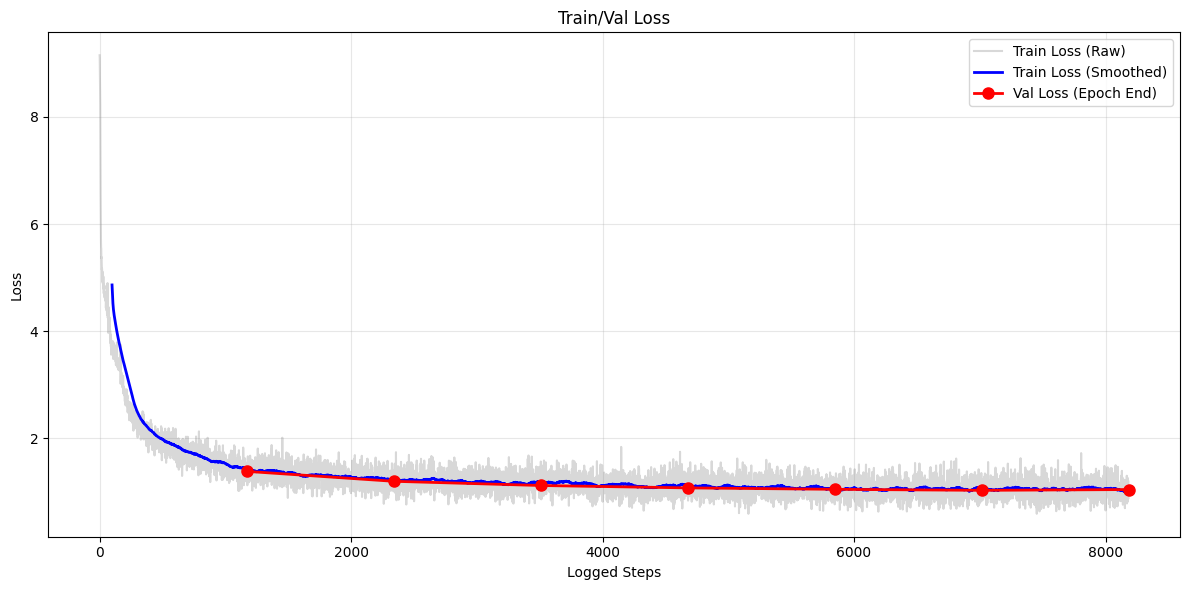

In [22]:
plt.figure(figsize=(12, 6))

plt.plot(losses, alpha=0.3, label='Train Loss (Raw)', color='gray')

# smoothed Training Loss
if len(losses) >= 100:
    window = 100
    smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(losses)), smoothed, color='blue', linewidth=2, label='Train Loss (Smoothed)')

# validation Loss
if len(val_losses) > 0:
    steps_per_epoch = len(losses) / len(val_losses)
    val_x_indices = [steps_per_epoch * (i + 1) for i in range(len(val_losses))]
    plt.plot(val_x_indices, val_losses, 'o-', color='red', linewidth=2, markersize=8, label='Val Loss (Epoch End)')

plt.xlabel('Logged Steps')
plt.ylabel('Loss')
plt.title('Train/Val Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()